In [325]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook
import time

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from diffNN import *
from BlackScholes import *

import sys
sys.path.insert(0, '/Users/tk/Documents/GitHub/Speciale/rBergomi')
from rBergomi import roughBergomi

tf.executing_eagerly()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [326]:
layers = 4
units = 20

size = 2 ** 17
n_epochs = 100 
batch_size = int(max(256, size // 16))
custom_training = False

type = 'BlackScholes' # 'Cliquet', 'Asian', 'European', 'BlackScholes'

T = 1 
H = 0.1
eta = 1
rho = -0.3
xi = 0.235**2
spot = 100
strike = 110

In [327]:
deriv = 0
lower = 35
upper = 165

if type == 'Cliquet':
    deriv = 1
    lower = 0.01
    upper = 0.15

if type == 'BlackScholes':
    bs = BlackScholes(K=1.1)
    spots, sigmas, yTrain, pathdelta, pathvega = bs.trainingSet(size)
    xTrain = np.c_[spots, sigmas]
    dydxTrain = np.c_[pathdelta, pathvega]
    x_mean, x_std, x, y_mean, y_std, y, dydx, lambd = normalize_data(xTrain, yTrain, dydxTrain)
    xTest, yTest, dydxTest = bs.testSet(num=100)
    x = x.astype(np.float32)
    y = y.astype(np.float32)
    dydx = dydx.astype(np.float32)

else:
    rB = roughBergomi(n_paths = size, n_steps = 52)
    volterra, W, dW = rB.simPaths(H=H, rho=rho)
    xTrain, yTrain, dydxTrain = rB.trainingSet(dW, volterra, spot=spot, strike=strike, xi=xi, eta=eta, payoff=type, deriv=deriv)
    x_mean, x_std, x, y_mean, y_std, y, dydx, lambd = normalize_data(xTrain, yTrain, dydxTrain)
    xTest, yTest, dydxTest = rB.testSet(dW, volterra, lower=lower, upper=upper, spot=spot, strike=strike, xi=xi, eta=eta, payoff=type, deriv=deriv)
    dydx = dydx.astype(np.float32)

if type == None:
    pass

In [328]:
nn = create_graph(layers=layers, units=units, input_dim=x.shape[1])

if custom_training:

    training_set = tf.data.Dataset.from_tensor_slices((x,y,dydx))
    training_set = training_set.batch(batch_size)

    for epoch in tqdm_notebook(range(n_epochs), desc = 'Training differential network'):

        lr = lr_scheduler(epoch, n_epochs)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        for step, (x_batch, y_batch, dydx_batch) in enumerate(training_set):

            with tf.GradientTape() as tape:
                yhat_batch, dydxhat_batch = nn(x_batch, training = True)
                loss_value = differential_mse(y_batch, yhat_batch, dydx_batch, dydxhat_batch, lambd)

            grads = tape.gradient(loss_value, nn.trainable_weights)
            optimizer.apply_gradients(zip(grads, nn.trainable_weights))

else:

    optimizer = tf.keras.optimizers.Adam(learning_rate=LRSchedule(n_epochs, size, batch_size))
    nn.compile(loss=['mse', create_derivsLoss(lambd)], optimizer=optimizer, run_eagerly = True)

    print('Training differential neural network... ')
    t0 = time.time()
    history = nn.fit(
        x, [y, dydx], epochs=n_epochs, batch_size = batch_size, verbose = 1
    )
    t1 = time.time()
    print('Training completed in {} seconds'.format(round(t1-t0, 2)))

Training differential neural network... 
Epoch 1/100
16/16 [==============================] - 1s 35ms/step - loss: 2.5519 - output_loss: 1.5807 - derivs_loss: 0.9712
Epoch 2/100
16/16 [==============================] - 1s 37ms/step - loss: 1.7110 - output_loss: 0.8496 - derivs_loss: 0.8614
Epoch 3/100
16/16 [==============================] - 1s 54ms/step - loss: 0.9369 - output_loss: 0.2687 - derivs_loss: 0.6682
Epoch 4/100
16/16 [==============================] - 1s 40ms/step - loss: 0.5995 - output_loss: 0.0944 - derivs_loss: 0.5051
Epoch 5/100
16/16 [==============================] - 1s 37ms/step - loss: 0.5347 - output_loss: 0.0732 - derivs_loss: 0.4614
Epoch 6/100
16/16 [==============================] - 1s 34ms/step - loss: 0.5181 - output_loss: 0.0677 - derivs_loss: 0.4503
Epoch 7/100
16/16 [==============================] - 1s 34ms/step - loss: 0.5088 - output_loss: 0.0663 - derivs_loss: 0.4425
Epoch 8/100
16/16 [==============================] - 1s 34ms/step - loss: 0.5026 - o

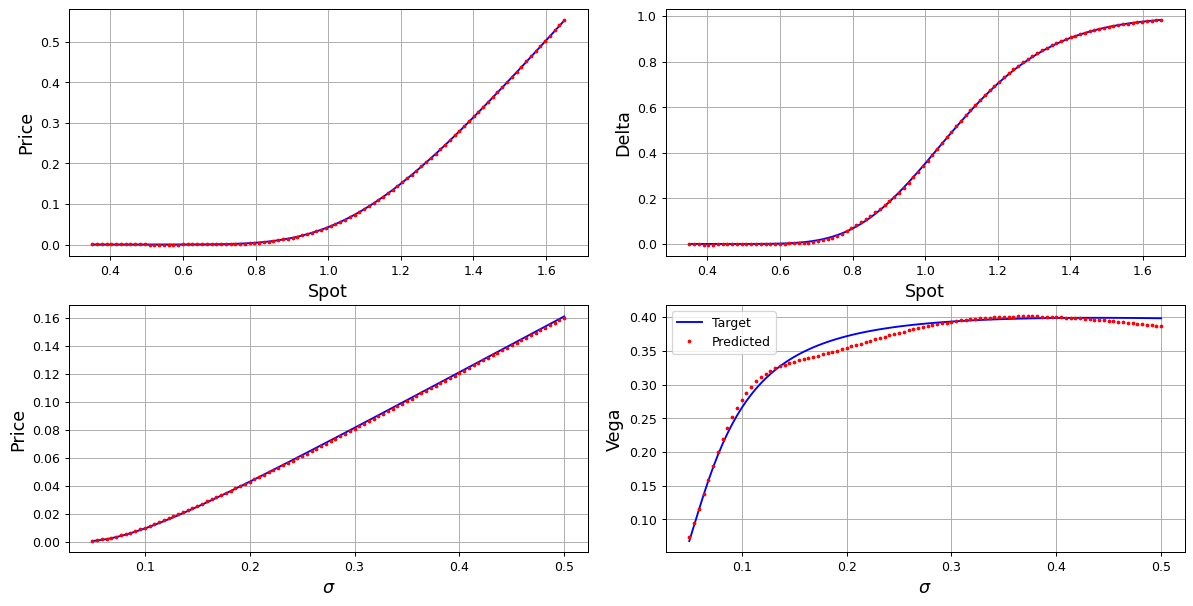

In [329]:
if type == 'BlackScholes':

    sig = np.linspace(0.05,0.5,100)
    constspt = np.repeat(1,100) 
    spt = np.linspace(0.35,1.65,100)
    constsig = np.repeat(0.2,100) 
    constsptsig = np.c_[constspt,sig]
    sptconstsig = np.c_[spt,constsig]

    constsptsig_scaled = (constsptsig - x_mean) / x_std
    constsptsig_y, constsptsig_dydx = nn.predict(constsptsig_scaled)
    constsptsig_yPred = y_mean + y_std * constsptsig_y
    constsptsig_dydxPred = y_std / x_std * constsptsig_dydx

    sptconstsig_scaled = (sptconstsig - x_mean) / x_std
    sptconstsig_y, sptconstsig_dydx = nn.predict(sptconstsig_scaled)
    sptconstsig_yPred = y_mean + y_std * sptconstsig_y
    sptconstsig_dydxPred = y_std / x_std * sptconstsig_dydx

    vprice = []
    for s in sig:
        vprice.append(bsPrice(1,1.1,s,1))

    vega = []
    for s in sig:
        vega.append(bsVega(1,1.1,s,1))

    sprice = []
    for s in spt:
        sprice.append(bsPrice(s,1.1,0.2,1))

    delta = []
    for s in spt:
        delta.append(bsDelta(s,1.1,0.2,1))

    fig, ax = plt.subplots(2, 2, squeeze=False, dpi=90)
    fig.set_size_inches(16, 8)
    fig.subplots_adjust(wspace=0.15)

    ax[0,1].plot(spt, delta, color='blue', label='Target')
    ax[0,1].plot(spt, sptconstsig_dydxPred[:,0], 'co', markersize=2, color='red', label='Predicted')
    ax[0,1].set_ylabel('Delta', fontsize=14)
    ax[0,1].set_xlabel('Spot', fontsize=14)

    ax[1,0].plot(sig, vprice, color='blue', label='Target')
    ax[1,0].plot(sig, constsptsig_yPred, 'co', markersize=2, color='red', label='Predicted')
    ax[1,0].set_ylabel('Price', fontsize=14)
    ax[1,0].set_xlabel(r'$\sigma$', fontsize=14)

    ax[1,1].plot(sig, vega, color='blue', label='Target')
    ax[1,1].plot(sig, constsptsig_dydxPred[:,1], 'co', markersize=2, color='red', label='Predicted')
    ax[1,1].set_ylabel('Vega', fontsize=14)
    ax[1,1].set_xlabel(r'$\sigma$', fontsize=14)

    ax[0,0].plot(spt, sprice, color='blue', label='Target')
    ax[0,0].plot(spt, sptconstsig_yPred, 'co', markersize=2, color='red', label='Predicted')
    ax[0,0].set_ylabel('Price', fontsize=14)
    ax[0,0].set_xlabel('Spot', fontsize=14)

    ax[0,0].grid(True)
    ax[0,1].grid(True)
    ax[1,0].grid(True)
    ax[1,1].grid(True)

    plt.legend(loc='upper left')

    plt.show()

else:
    
    x_scaled = (xTest - x_mean) / x_std
    y_scaled, dydx_scaled = nn.predict(x_scaled)
    yPred = y_mean + y_std * y_scaled
    dydxPred = y_std / x_std * dydx_scaled

    fig, ax = plt.subplots(1, 2, squeeze=False, dpi=90)
    fig.set_size_inches(9.5, 4)
    ax[0,0].plot(xTest,dydxPred, 'co', markersize=2, color='red', label='Predicted')
    ax[0,0].plot(xTest,dydxTest, color='blue', label='Monte Carlo')
    ax[0,1].plot(xTest,yPred, 'co', markersize=2, color='red', label='Predicted')
    ax[0,1].plot(xTest,yTest, color='blue', label='Monte Carlo')
    ax[0,0].set_ylabel("Derivative")
    ax[0,1].set_ylabel("Price")
    ax[0,0].set_xlabel(r"$\xi_0$")
    ax[0,1].set_xlabel(r"$\xi_0$")
    errors = (dydxPred - dydxTest)
    rmse = np.sqrt((errors ** 2).mean(axis=0))
    t = "RMSE = %.2f" % rmse
    ax[0,0].set_title(t)
    errors = 100*(yPred - yTest)
    rmse = np.sqrt((errors ** 2).mean(axis=0)); rmse
    t = "RMSE = %.2f" % rmse
    ax[0,1].set_title(t)
    t = "Size = %.0f" % size
    plt.suptitle(t)
    ax[0,0].legend()
    plt.show()


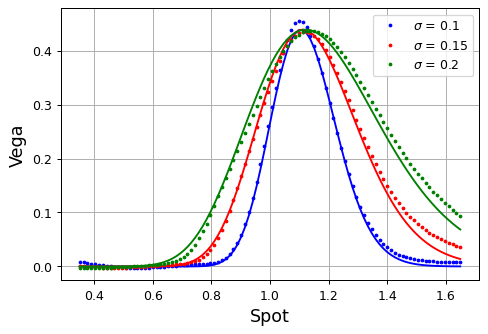

In [330]:
if type == 'BlackScholes':    
    spt = np.linspace(0.35,1.65,100)
    sigs = [0.1, 0.15, 0.20]
    col = ['blue', 'red', 'green']
    i = 0
    fig = plt.subplots(1, 1, squeeze=False, dpi=90)
    for s in sigs:
        sig = np.repeat(s,100) 
        x = np.c_[spt, sig]
        x_scaled = (x - x_mean) / x_std
        y_scaled, dydx_scaled = nn.predict(x_scaled)
        y_pred = y_mean + y_std * y_scaled
        dydx_pred = y_std / x_std * dydx_scaled
        vega = []
        for spot in spt:
            vega.append(bsVega(spot,1.1,s,1))
        plt.plot(spt, vega, col[i])
        plt.plot(spt, dydx_pred[:,1], 'co', markersize=2, color=col[i], label=r'$\sigma$ = {}'.format(s))
        i += 1

    plt.xlabel('Spot', fontsize=14)
    plt.ylabel('Vega', fontsize=14)
    plt.grid(True)
    plt.legend()